In [1]:
import pandas as pd
import numpy as np
import datetime
import seaborn as sb
import time
#from ipywidgets import interact, fixed
from libs.CovidTimeseriesModel import CovidTimeseriesModel 
from libs.CovidTimeseriesModelSIR import CovidTimeseriesModelSIR
from libs.CovidDatasets import CDSDataset
pd.set_option('display.float_format', lambda x: '%.2f' % x)

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
%matplotlib inline

import matplotlib.pyplot as plt

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [4]:
Dataset = CDSDataset()

def model_state(country, state, interventions=None):
   
    ## Constants
    start_time = time.time()
    HOSPITALIZATION_RATE = .0727
    HOSPITALIZED_CASES_REQUIRING_ICU_CARE = .1397
    TOTAL_INFECTED_PERIOD = 12
    MODEL_INTERVAL = 4
    r0 = 2.4
    POP = Dataset.get_population_by_country_state(country, state)
    # Pack all of the assumptions and parameters into a dict that can be passed into the model
    MODEL_PARAMETERS = {
        # Pack the changeable model parameters
        'timeseries': Dataset.get_timeseries_by_country_state(country, state, MODEL_INTERVAL),
        'beds': Dataset.get_beds_by_country_state(country, state),
        'population': POP,
        #'projection_iterations': 25, # Number of iterations into the future to project
        'projection_iterations': 80, # Number of iterations into the future to project
        'r0': r0,
        'interventions': interventions,
        'hospitalization_rate': HOSPITALIZATION_RATE,
        'case_fatality_rate': .0109341104294479,
        'hospitalized_cases_requiring_icu_care': HOSPITALIZED_CASES_REQUIRING_ICU_CARE,
        # Assumes that anyone who needs ICU care and doesn't get it dies
        'case_fatality_rate_hospitals_overwhelmed': HOSPITALIZATION_RATE * HOSPITALIZED_CASES_REQUIRING_ICU_CARE,
        'hospital_capacity_change_daily_rate': 1.05,
        'max_hospital_capacity_factor': 2.07,
        'initial_hospital_bed_utilization': .6,
        'model_interval': 4, # In days
        'total_infected_period': 12, # In days
        'rolling_intervals_for_current_infected': int(round(TOTAL_INFECTED_PERIOD / MODEL_INTERVAL, 0)),
        'estimated_new_cases_per_death': 32,
        'estimated_new_cases_per_confirmed': 20,
        # added for seird model
        'incubation_period': 5, # In days
        'duration_mild_infections': 10, # In days
        'icu_time_death': 7, #Time from ICU admission to death, In days
        'hospital_time_recovery': 11, #Duration of hospitalization, In days
        'use_harvard_params': True, #If True use the harvard parameters directly, if not calculate off the above
        'use_harvard_init': use_harvard_init, #If True use the harvard model inputs for inital conditions and N (recreate their graph)
    }
    return CovidTimeseriesModelSIR().forecast_region(model_parameters=MODEL_PARAMETERS)

r0 = 2.4

INTERVENTIONS = [
    None, 
    {
        datetime.date(2020, 3, 23): 1.3,
        datetime.date(2020, 4, 20): 1.1,
        datetime.date(2020, 5, 22): 0.8,
        datetime.date(2020, 6, 23): r0
    },
    {
        datetime.date(2020, 3, 23): 1.7,
        datetime.date(2020, 6, 23): r0
    },
    {
        datetime.date(2020, 3, 23): 1.3,
        datetime.date(2020, 3, 31): 0.3,
        datetime.date(2020, 4, 28): 0.2,
        datetime.date(2020, 5,  6): 0.1,
        datetime.date(2020, 5, 10): 0.35,
        datetime.date(2020, 5, 18): r0
    }
]

In [5]:
# Dataset.get_timeseries_by_country_state('USA', 'TX', 1)[['date','cases','deaths','recovered','active']]

In [6]:
def plot_df(df, cols):
    cols.append('date')
    
    df = df.loc[:, cols]


    df.set_index('date', inplace=True)
    
    stacked = df.stack().reset_index()
    
    stacked.columns = ['date', 'Population', 'Number of people']
    
    plt.figure(figsize=(15,8))
    df_plt = sb.lineplot(x='date', y='Number of people', hue='Population', data=stacked)

    return(df_plt)

In [7]:
# Params with True
# [1. 0. 0. 0. 0. 0.]
# [0.0, 0.00025, 0.0, 0.0] 0.2 [0.0, 0.08, 0.06818182, 0.08571429] [0.0, 0.02, 0.02272727] 0.057142857142857134 1000

# params with False
# [1. 0. 0. 0. 0. 0.]
# [0.0, 0.00025, 0.0, 0.0] 0.2 [0.0, 0.08, 0.06818182, 0.08571429] [0.0, 0.02, 0.02272727] 0.057142857142857134 28995881.0

In [8]:
#use_harvard_init = False #If True use the harvard model inputs for inital conditions and N (recreate their graph)
use_harvard_init = True #If True use the harvard model inputs for inital conditions and N (recreate their graph)

In [9]:
[df, soln] = model_state('USA', 'TX', INTERVENTIONS[0])

if use_harvard_init:
    df.index.name = 'date'
    df.reset_index(inplace=True)

           city county state country  population   lat    long  \
dt                                                               
2020-03-19  NaN    NaN    TX     USA 28995881.00 31.18 -100.09   
2020-03-20  NaN    NaN    TX     USA 28995881.00 31.18 -100.09   
2020-03-21  NaN    NaN    TX     USA 28995881.00 31.18 -100.09   
2020-03-22  NaN    NaN    TX     USA 28995881.00 31.18 -100.09   
2020-03-23  NaN    NaN    TX     USA 28995881.00 31.18 -100.09   

                                             url  cases  deaths  recovered  \
dt                                                                           
2020-03-19  https://covidtracking.com/api/states 143.00    3.00       0.00   
2020-03-20  https://covidtracking.com/api/states 194.00    5.00       0.00   
2020-03-21  https://covidtracking.com/api/states 304.00    5.00       0.00   
2020-03-22  https://covidtracking.com/api/states 334.00    5.00       0.00   
2020-03-23  https://covidtracking.com/api/states 352.00    8.00      

[1154418.89109298   45439.70982269   90878.40644309   19993.24529114
    3180.74230207 2290817.21948845   45271.78555957]
(3650, 7)


(1, 1000)

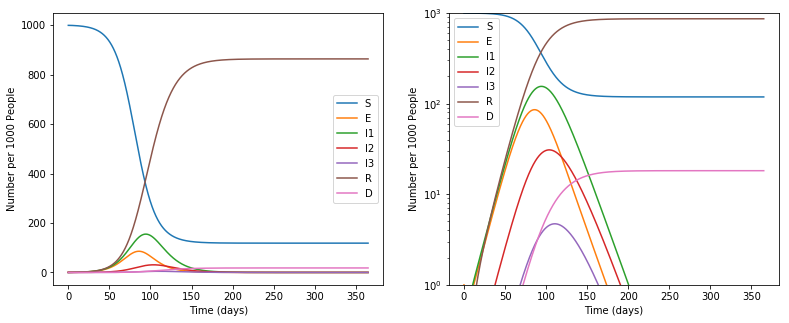

In [10]:
if use_harvard_init:
    tmax=365
    N = 1000
    tvec=np.arange(0,tmax,0.1)
else:
    # tmax = 80 * 4
    tmax = 365
    N = 28995881.00 
    tvec=np.arange(0,tmax,0.1)

soln_plt = np.hstack((N-np.sum(soln,axis=1,keepdims=True),soln))

print(sum(soln_plt))
print(soln_plt.shape)

plt.figure(figsize=(13,5))
plt.subplot(1,2,1)
plt.plot(tvec,soln_plt)
plt.xlabel("Time (days)")
plt.ylabel("Number per 1000 People")
plt.legend(("S","E","I1","I2","I3","R","D"))
#plt.ylim([0,N])

#Same plot but on log scale
plt.subplot(1,2,2)
plt.plot(tvec,soln_plt)
plt.semilogy()
plt.xlabel("Time (days)")
plt.ylabel("Number per 1000 People")
plt.legend(("S","E","I1","I2","I3","R","D"))
plt.ylim([1,N])
#plt.tight_layout()

In [11]:
df.tail(25)

,date,exposed,infected_a,infected_b,infected_c,recovered,dead,infected,total,susceptible
3625,2021-03-20 14:23:03.173472184,0.00,0.00,0.00,0.00,863.34,18.18,0.00,1000,118.48
3626,2021-03-20 16:47:05.541244180,0.00,0.00,0.00,0.00,863.34,18.18,0.00,1000,118.48
3627,2021-03-20 19:11:07.909016172,0.00,0.00,0.00,0.00,863.34,18.18,0.00,1000,118.48
3628,2021-03-20 21:35:10.276788164,0.00,0.00,0.00,0.00,863.34,18.18,0.00,1000,118.48
3629,2021-03-20 23:59:12.644560156,0.00,0.00,0.00,0.00,863.34,18.18,0.00,1000,118.48
3630,2021-03-21 02:23:15.012332148,0.00,0.00,0.00,0.00,863.34,18.18,0.00,1000,118.48
3631,2021-03-21 04:47:17.380104140,0.00,0.00,0.00,0.00,863.34,18.18,0.00,1000,118.48
3632,2021-03-21 07:11:19.747876132,0.00,0.00,0.00,0.00,863.34,18.18,0.00,1000,118.48
3633,2021-03-21 09:35:22.115648124,0.00,0.00,0.00,0.00,863.34,18.18,0.00,1000,118.48
3634,2021-03-21 11:59:24.483420116,0.00,0.00,0.00,0.00,863.34,18.18,0.00,1000,118.48


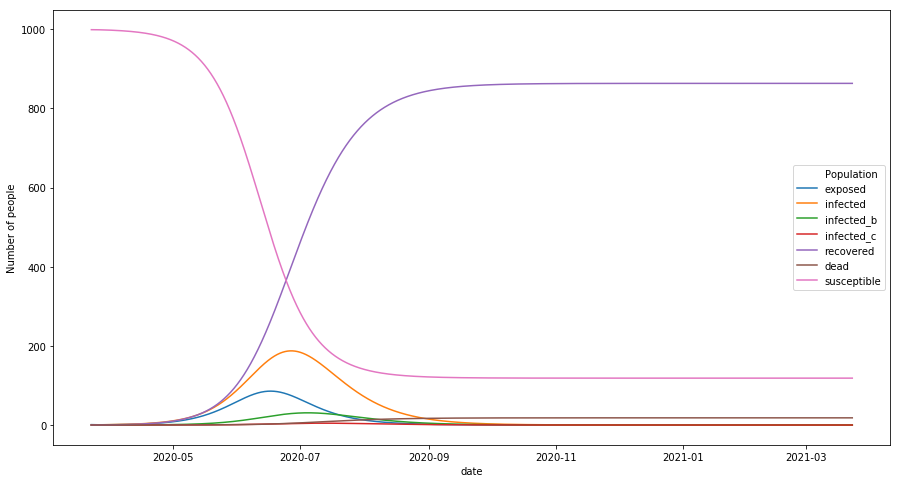

In [12]:
chart_cols = ["exposed", "infected", "infected_b", "infected_c",  "recovered", "dead", "susceptible"]

plot_df(df, chart_cols)